In [ ]:
import pandas as pd
from google.colab import drive

In [ ]:
raw_data = '/content/drive/My Drive/ist718_data/data_group3/data.csv'

In [ ]:
drive.mount('/content/drive')
raw_data = pd.read_csv(raw_data)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install pyspark

In [ ]:
enable_grid_search = False

In [ ]:
# import statements
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import pandas as pd
import numpy as np
%matplotlib inline
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.ml import feature
from pyspark.ml import classification
from pyspark.sql import functions as fn
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import seaborn as sns
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)
import os
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer, PolynomialExpansion, VectorAssembler,StandardScaler
import pyspark.sql.functions as fn
from pyspark.ml.linalg import Vectors
from pyspark import keyword_only
from pyspark.ml import Transformer
from pyspark.ml.functions import vector_to_array
from pyspark.ml.param.shared import HasOutputCols, Param, Params
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.sql.functions import lit
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import FloatType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DateType
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import isnan, isnull, when, count, col

### Data Loading / Preprocessing

In [ ]:
spotify_2015_2020 = raw_data[raw_data['year']>=2015]
spotify_2015_2020.reset_index(drop=True, inplace=True)
spotify_2015_2020 = spotify_2015_2020.drop(['id'], axis=1)
spotify_df = spark.createDataFrame(spotify_2015_2020)

### Data Exploration

In [ ]:
spotify_df.dtypes

[('acousticness', 'double'),
 ('artists', 'string'),
 ('danceability', 'double'),
 ('duration_ms', 'bigint'),
 ('energy', 'double'),
 ('explicit', 'bigint'),
 ('instrumentalness', 'double'),
 ('key', 'bigint'),
 ('liveness', 'double'),
 ('loudness', 'double'),
 ('mode', 'bigint'),
 ('name', 'string'),
 ('popularity', 'bigint'),
 ('release_date', 'string'),
 ('speechiness', 'double'),
 ('tempo', 'double'),
 ('valence', 'double'),
 ('year', 'bigint')]

In [ ]:
spotify_df.describe().show()

+-------+-------------------+--------------------+------------------+-----------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+------------------+--------------------+------------------+------------------+-------------------+------------------+------------------+------------------+
|summary|       acousticness|             artists|      danceability|      duration_ms|             energy|           explicit|   instrumentalness|               key|           liveness|          loudness|              mode|                name|        popularity|      release_date|        speechiness|             tempo|           valence|              year|
+-------+-------------------+--------------------+------------------+-----------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+------------------+--------------------+------------------+--------------

In [ ]:
spotify_pd = spotify_df.toPandas()

In [ ]:
spotify_pd.corr()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
acousticness,1.000000,-0.263156,-0.077792,-0.654377,-0.155874,0.332358,-0.003199,-0.111151,-0.547990,0.061326,-0.005684,-0.100944,-0.174029,-0.191527,0.004055
danceability,-0.263156,1.000000,-0.134569,0.173566,0.376097,-0.431719,0.012573,-0.128941,0.422928,-0.095558,0.108730,0.283238,0.084128,0.427345,0.163203
duration_ms,-0.077792,-0.134569,1.000000,0.100764,-0.072978,-0.107606,0.014017,0.021613,0.135901,0.001978,-0.105685,-0.098234,0.033308,-0.110821,-0.187694
energy,-0.654377,0.173566,0.100764,1.000000,0.030996,-0.355088,0.040809,0.165100,0.694154,-0.063486,-0.031014,0.036628,0.203082,0.378748,-0.035963
explicit,-0.155874,0.376097,-0.072978,0.030996,1.000000,-0.201062,-0.019126,0.012922,0.115420,-0.122698,0.079746,0.459156,0.080458,-0.008824,0.146682
instrumentalness,0.332358,-0.431719,-0.107606,-0.355088,-0.201062,1.000000,-0.046900,0.077347,-0.697199,0.037342,-0.026528,-0.138082,-0.191059,-0.295401,-0.032514
key,-0.003199,0.012573,0.014017,0.040809,-0.019126,-0.046900,1.000000,0.002132,0.051983,-0.135018,-0.005551,0.008060,0.019485,0.052410,-0.000434
liveness,-0.111151,-0.128941,0.021613,0.165100,0.012922,0.077347,0.002132,1.000000,0.004779,-0.011983,-0.033823,0.042360,-0.023400,-0.019199,-0.039652
loudness,-0.547990,0.422928,0.135901,0.694154,0.115420,-0.697199,0.051983,0.004779,1.000000,-0.056923,0.021323,0.044375,0.243263,0.392856,0.003374
mode,0.061326,-0.095558,0.001978,-0.063486,-0.122698,0.037342,-0.135018,-0.011983,-0.056923,1.000000,-0.030603,-0.099898,0.005975,-0.026338,-0.013786


In [ ]:
spotify_pd.cov()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
acousticness,0.082264,-0.013248,-1.220438e+03,-0.039588,-0.021794,0.020621,-0.003305,-0.004549,-0.798586,0.008532,-0.017430,-0.003410,-1.560123,-0.012751,0.001956
danceability,-0.013248,0.030807,-1.291953e+03,0.006426,0.032180,-0.016392,0.007949,-0.003229,0.377167,-0.008136,0.204038,0.005855,0.461524,0.017410,0.048172
duration_ms,-1220.437750,-1291.952568,2.991945e+09,1162.538409,-1945.919297,-1273.239185,2761.755134,168.695143,37769.558665,52.488571,-61805.586918,-632.800443,56944.860385,-1407.020073,-17265.156884
energy,-0.039588,0.006426,1.162538e+03,0.044489,0.003187,-0.016202,0.031005,0.004969,0.743917,-0.006496,-0.069940,0.000910,1.338837,0.018543,-0.012756
explicit,-0.021794,0.032180,-1.945919e+03,0.003187,0.237639,-0.021202,-0.033585,0.000899,0.285880,-0.029014,0.415627,0.026360,1.225905,-0.000998,0.120248
instrumentalness,0.020621,-0.016392,-1.273239e+03,-0.016202,-0.021202,0.046794,-0.036545,0.002388,-0.766292,0.003918,-0.061354,-0.003518,-1.291791,-0.014832,-0.011828
key,-0.003305,0.007949,2.761755e+03,0.031005,-0.033585,-0.036545,12.975309,0.001096,0.951408,-0.235921,-0.213781,0.003419,2.193731,0.043820,-0.002632
liveness,-0.004549,-0.003229,1.686951e+02,0.004969,0.000899,0.002388,0.001096,0.020363,0.003465,-0.000829,-0.051602,0.000712,-0.104368,-0.000636,-0.009515
loudness,-0.798586,0.377167,3.776956e+04,0.743917,0.285880,-0.766292,0.951408,0.003465,25.815788,-0.140296,1.158315,0.026553,38.632225,0.463315,0.028831
mode,0.008532,-0.008136,5.248857e+01,-0.006496,-0.029014,0.003918,-0.235921,-0.000829,-0.140296,0.235304,-0.158714,-0.005707,0.090589,-0.002966,-0.011246


In [ ]:
spotify_df.select([count(when(isnull(c), c)).alias(c) for c in spotify_df.columns]).show()
spotify_df.select([count(when(isnan(c), c)).alias(c) for c in spotify_df.columns]).show()

+------------+-------+------------+-----------+------+--------+----------------+---+--------+--------+----+----+----------+------------+-----------+-----+-------+----+
|acousticness|artists|danceability|duration_ms|energy|explicit|instrumentalness|key|liveness|loudness|mode|name|popularity|release_date|speechiness|tempo|valence|year|
+------------+-------+------------+-----------+------+--------+----------------+---+--------+--------+----+----+----------+------------+-----------+-----+-------+----+
|           0|      0|           0|          0|     0|       0|               0|  0|       0|       0|   0|   0|         0|           0|          0|    0|      0|   0|
+------------+-------+------------+-----------+------+--------+----------------+---+--------+--------+----+----+----------+------------+-----------+-----+-------+----+

+------------+-------+------------+-----------+------+--------+----------------+---+--------+--------+----+----+----------+------------+-----------+-----+-----

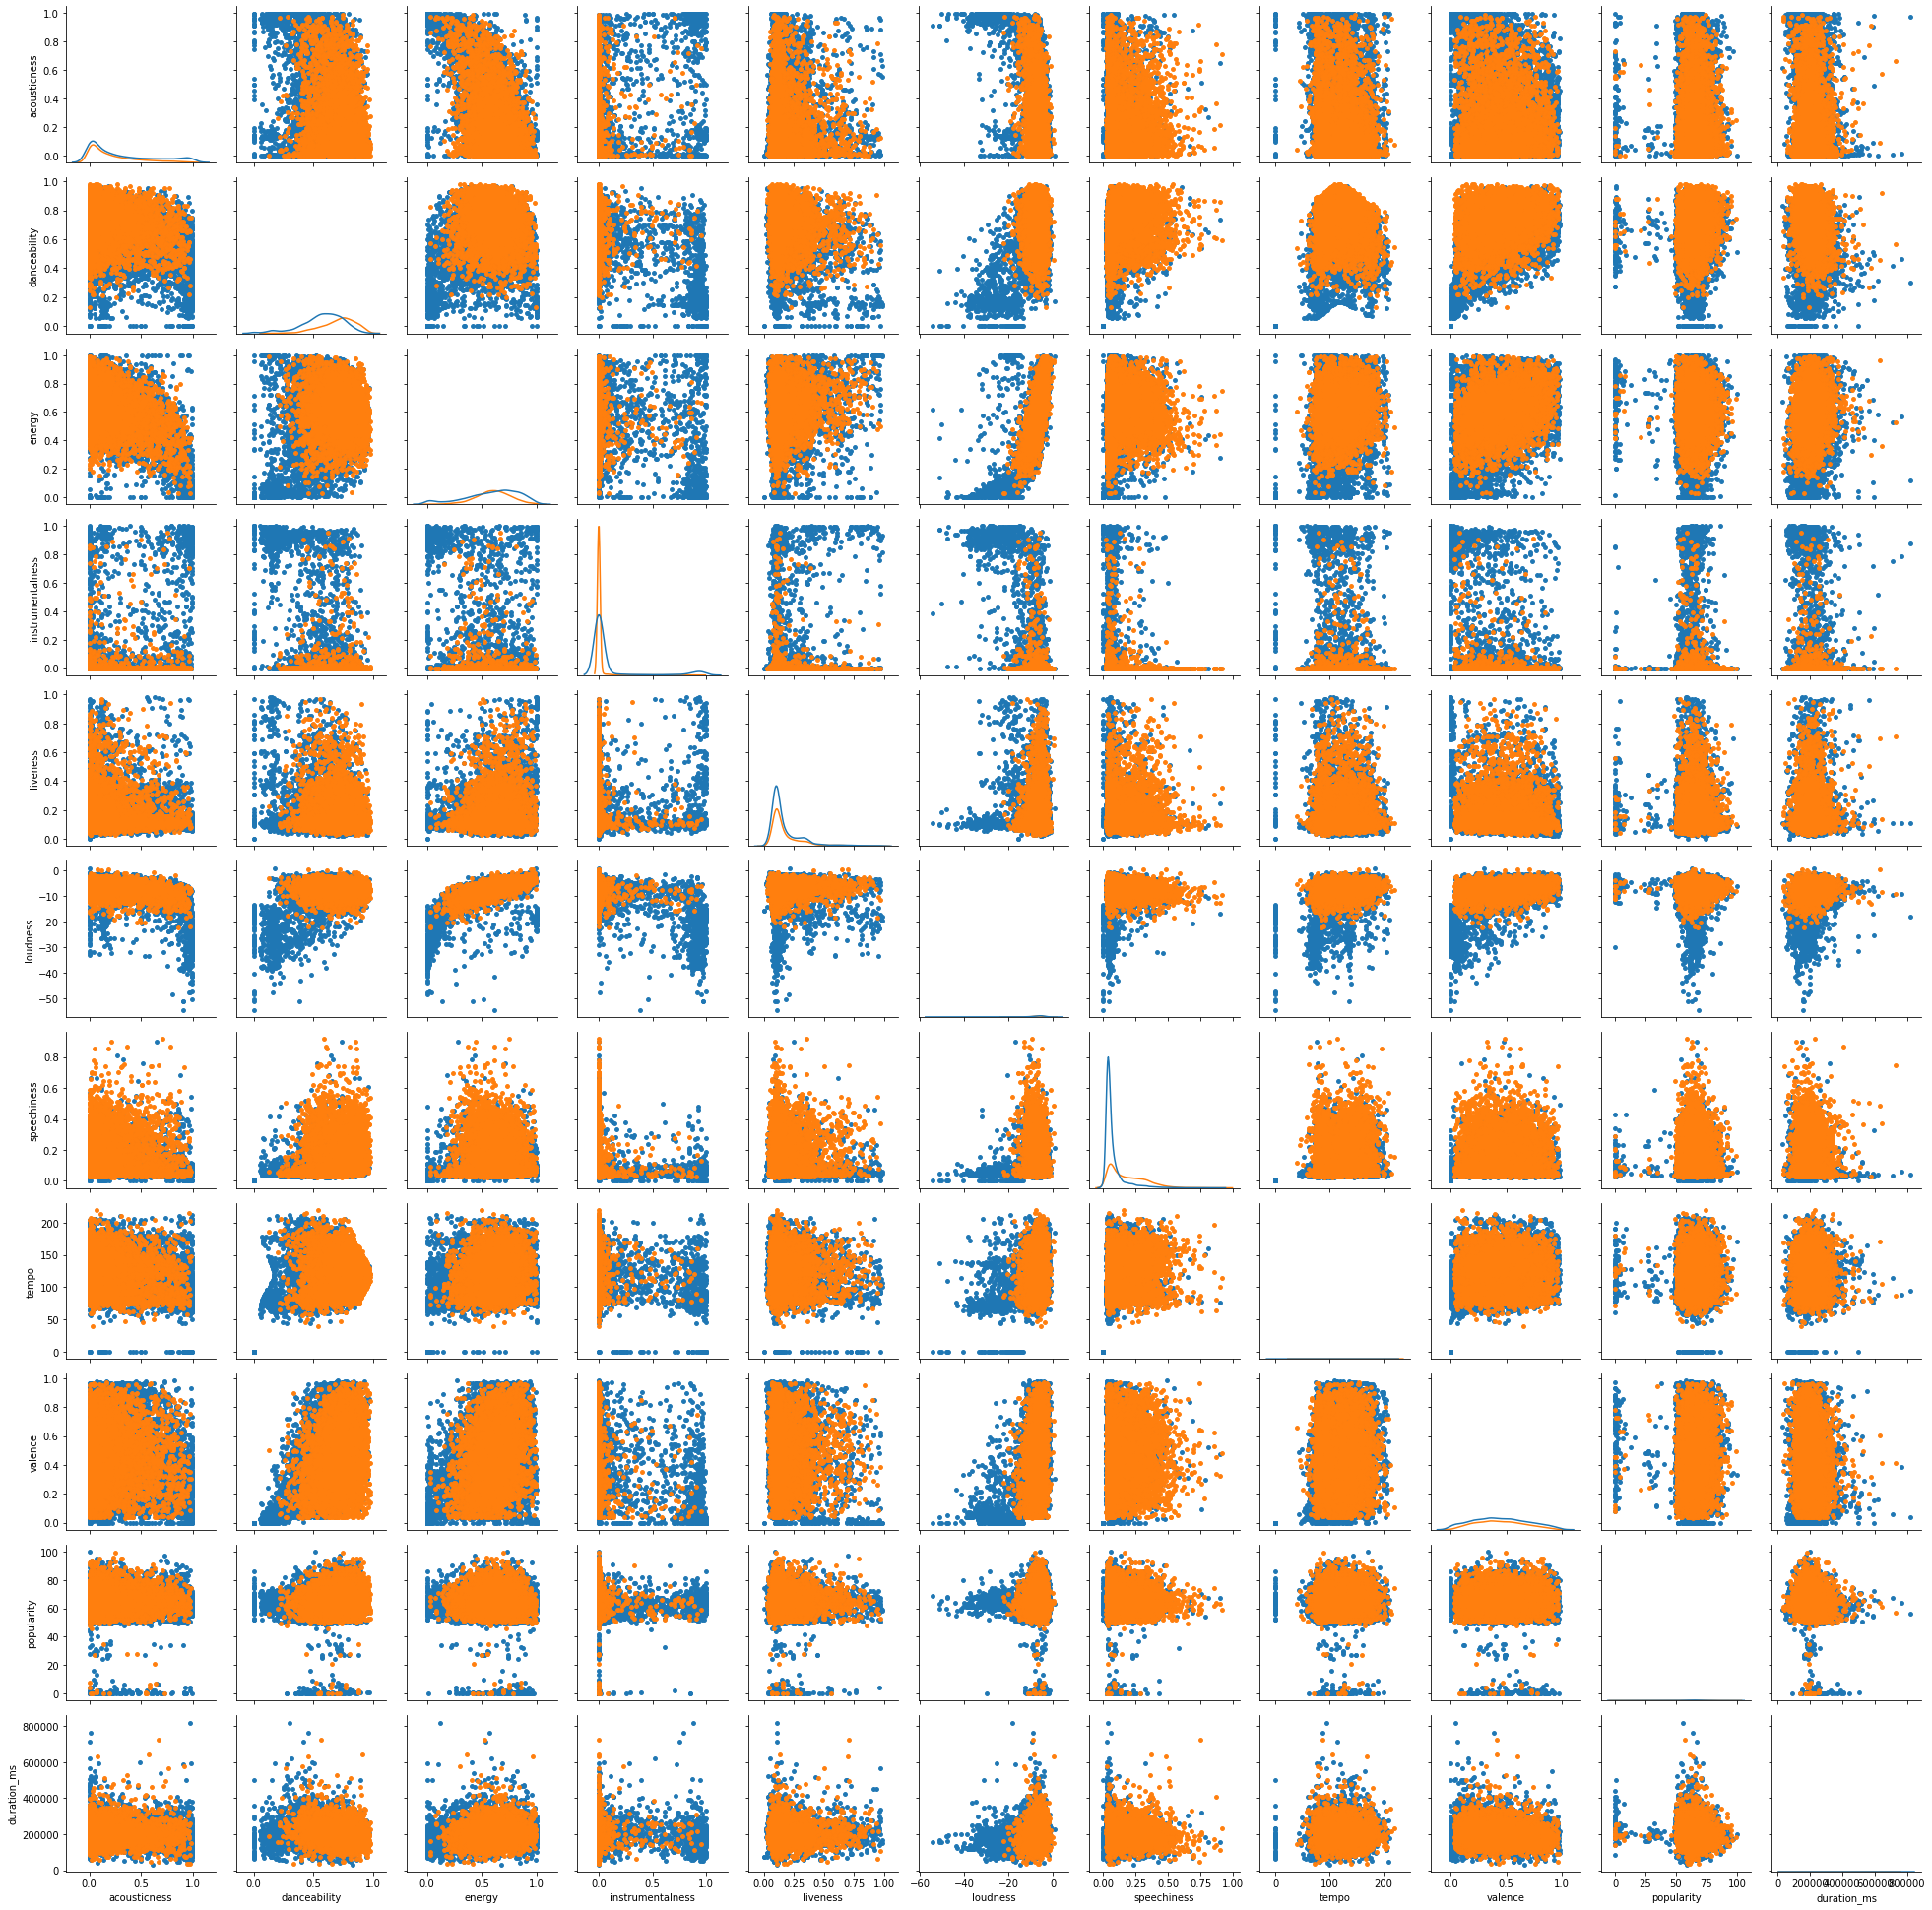

In [ ]:
p = sns.PairGrid(spotify_pd, vars=['acousticness','danceability','energy','instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo','valence','popularity','duration_ms'],hue='explicit')
p.map_diag(sns.kdeplot) # kernal density instead of scatter plot
p.map_offdiag(plt.scatter, s=15)

### Data Visualization

Text(0.5, 1.0, 'Popularity Frequency from 1921 to 2020')

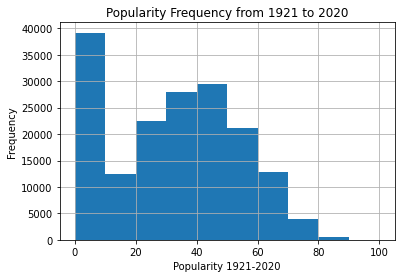

In [ ]:
# Popularity distribution from the original data (1921 - 2020)
raw_data['popularity'].hist()
plt.xlabel('Popularity 1921-2020')
plt.ylabel('Frequency')
plt.title('Popularity Frequency from 1921 to 2020')

Text(0.5, 1.0, 'Popularity Frequency from 2015 to 2020')

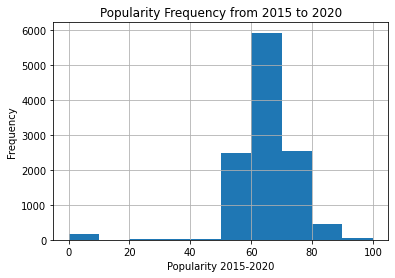

In [ ]:
# Popularity distribution from the recent data (2015 - 2020)
spotify_2015_2020['popularity'].hist()
plt.xlabel('Popularity 2015-2020')
plt.ylabel('Frequency')
plt.title('Popularity Frequency from 2015 to 2020')

In [ ]:
# isolate numeric columns only to analyze annual trend 
spotify_num = spotify_2015_2020.drop(['artists', 'explicit', 'mode', 'name', 'release_date', 'key'], axis=1)
year_trend = spotify_num.groupby('year').mean().drop(['duration_ms','tempo', 'popularity', 'loudness'], axis=1)
year_trend

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence
year,,,,,,,
2015,0.246801,0.591008,0.633499,0.058262,0.187513,0.095743,0.443944
2016,0.280290,0.599976,0.592877,0.074646,0.180198,0.107298,0.430769
2017,0.289916,0.612286,0.586739,0.098209,0.194218,0.111752,0.414465
2018,0.271941,0.664930,0.590591,0.035948,0.171781,0.128140,0.447141
2019,0.289298,0.644215,0.578796,0.076518,0.167161,0.124799,0.465856
2020,0.247374,0.673077,0.611914,0.039052,0.177048,0.143505,0.482755


Text(0.5, 1.0, 'Trend in Songs from 2015 to 2020')

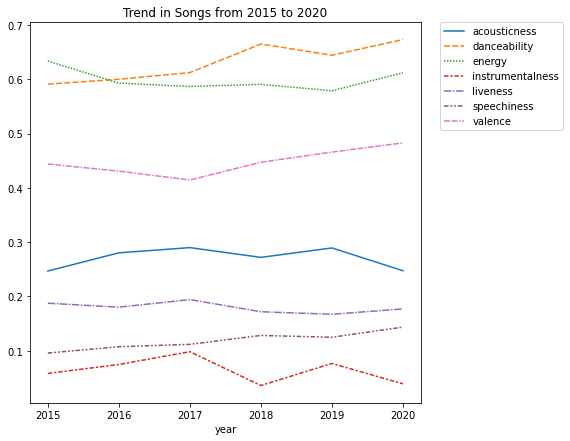

In [ ]:
# plot yearly trend
plt.subplots(figsize=(7,7))
sns.lineplot(data=year_trend)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Trend in Songs from 2015 to 2020')

No handles with labels found to put in legend.


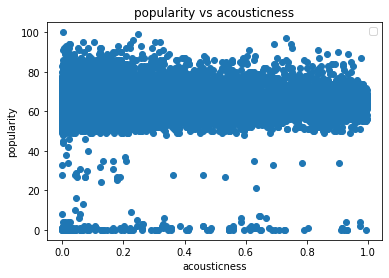

No handles with labels found to put in legend.


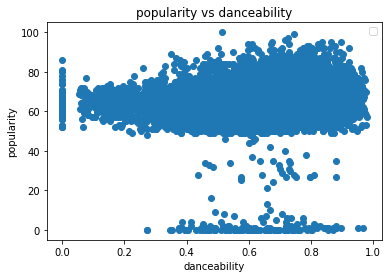

No handles with labels found to put in legend.


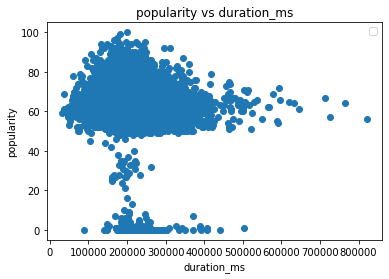

No handles with labels found to put in legend.


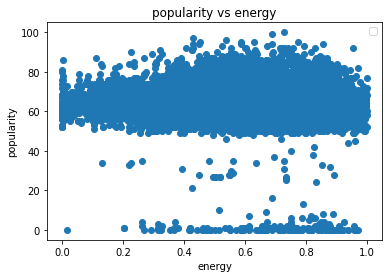

No handles with labels found to put in legend.


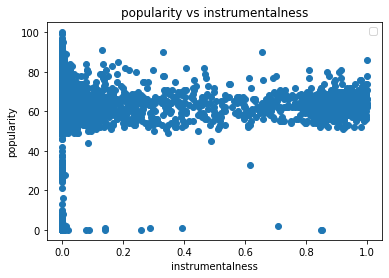

No handles with labels found to put in legend.


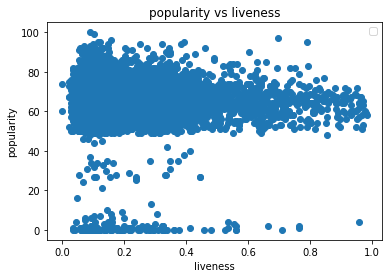

No handles with labels found to put in legend.


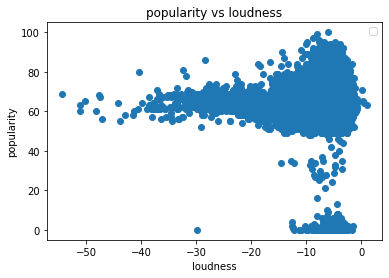

No handles with labels found to put in legend.


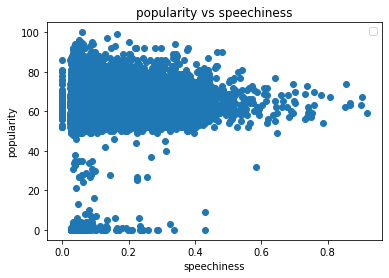

No handles with labels found to put in legend.


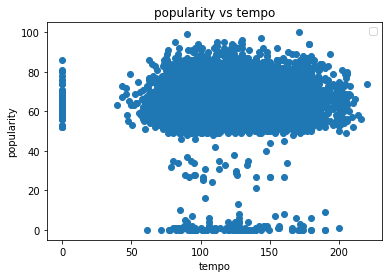

No handles with labels found to put in legend.


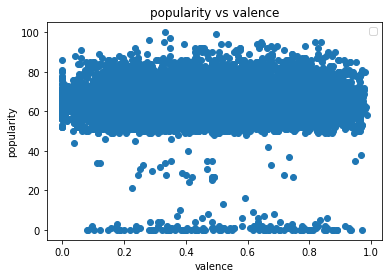

No handles with labels found to put in legend.


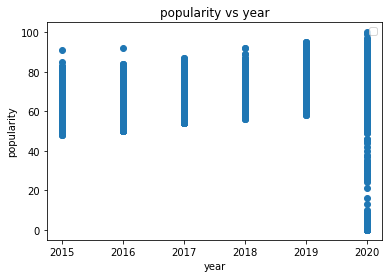

In [ ]:
# plot popularity vs all other columns
y_col = 'popularity'
x_columns = spotify_num.columns.drop('popularity')

for x_col in x_columns:

    figure = plt.figure
    ax = plt.gca()
    ax.scatter(spotify_num[x_col], spotify_num[y_col])
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title("{} vs {}".format(y_col, x_col))

    plt.legend()
    plt.show()

No handles with labels found to put in legend.


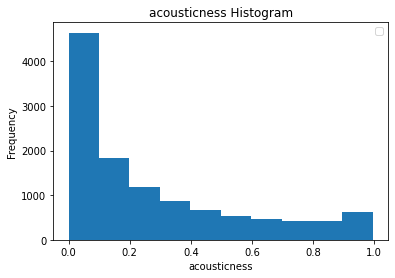

No handles with labels found to put in legend.


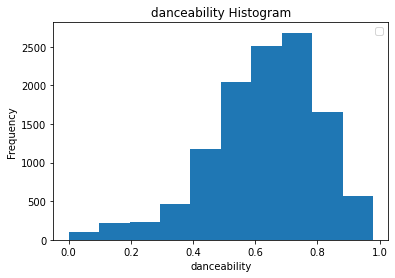

No handles with labels found to put in legend.


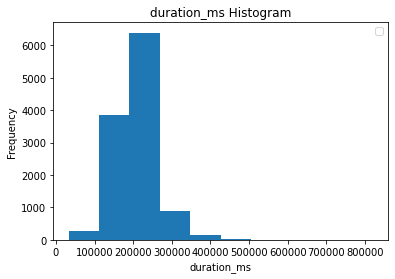

No handles with labels found to put in legend.


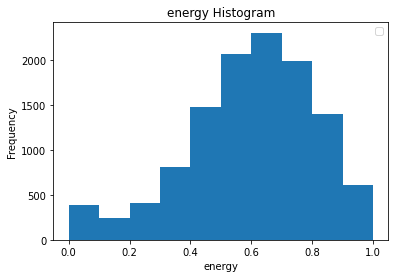

No handles with labels found to put in legend.


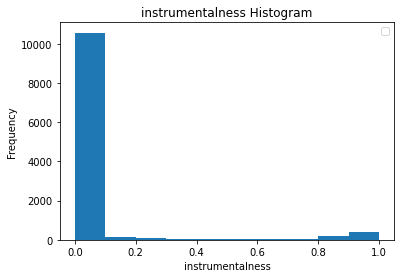

No handles with labels found to put in legend.


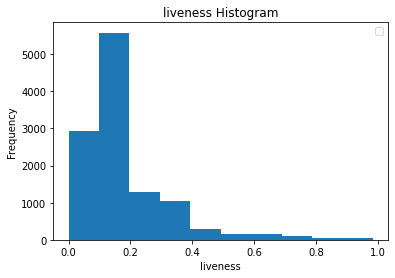

No handles with labels found to put in legend.


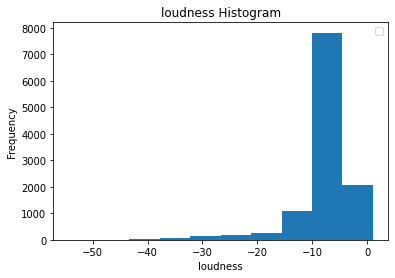

No handles with labels found to put in legend.


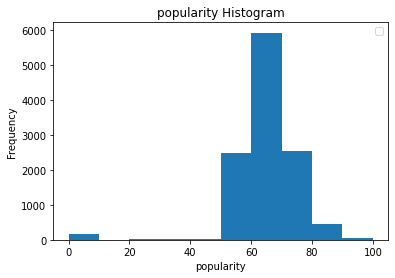

No handles with labels found to put in legend.


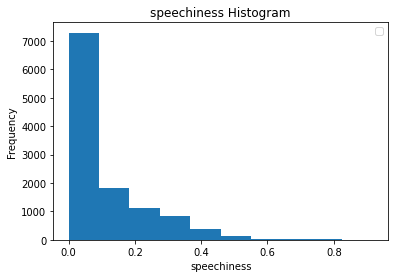

No handles with labels found to put in legend.


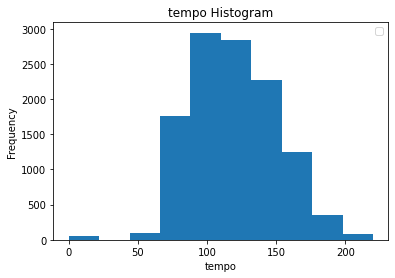

No handles with labels found to put in legend.


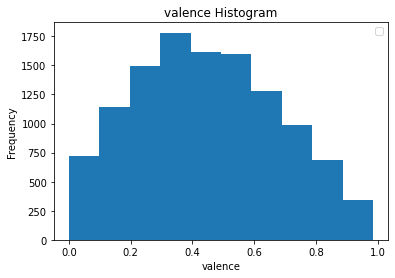

No handles with labels found to put in legend.


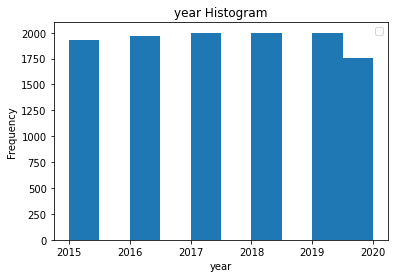

In [ ]:
# plot histogram of all columns to observe the distribution in the columns
x_columns = spotify_num.columns

for x_col in x_columns:

    figure = plt.figure
    ax = plt.gca()
    ax.hist(spotify_num[x_col])
    ax.set_xlabel(x_col)
    ax.set_ylabel('Frequency')
    ax.set_title("{} Histogram".format(x_col))

    plt.legend()
    plt.show()

### Model

#### Linear Regression

In [ ]:
# split data
train, test, val = spotify_df_xformed.randomSplit([0.7,0.2, 0.1],seed = 11)

In [ ]:
from pyspark.ml.feature import VectorAssembler


Assembler = VectorAssembler(inputCols = ['danceability', 'energy', 'loudness', 'explicit', 'key'],outputCol = 'features')
feature_engineering_pipe = Pipeline(stages = [Assembler])
model = feature_engineering_pipe.fit(spotify_df)
spotify_df_xformed = model.transform(spotify_df)

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import SQLContext
#from pyspark.mllib.linalg import Vectors
from pyspark.ml.linalg import Vectors, VectorUDT

# initial linear regression
linear_reg = LinearRegression(featuresCol="features",labelCol="popularity")
spotify_pipe = Pipeline(stages=[linear_reg])
model1 = spotify_pipe.fit(train)
linear_model = model1.stages[0]
print("Coefficients: " + str(linear_model.coefficients))
print("Intercept: " + str(linear_model.intercept))
model1_output = linear_model.transform(train)
trainingSummary = linear_model.summary
print("RMSE of Linear Regression Model: %f" % trainingSummary.rootMeanSquaredError)
#print("r2: %f" % trainingSummary.r2)
model1_evaluator = RegressionEvaluator(predictionCol="prediction",metricName="mse",labelCol='popularity')
print(model1_evaluator.metricName)
print('training MSE value: ',model1_evaluator.evaluate(model1_output))
print('testing MSE value: ',model1_evaluator.evaluate(linear_model.transform(test)))

Coefficients: [6.5244851235076755,-3.830540757449093,0.032646833011811295,1.042314540699992,-0.004156936054751057]
Intercept: 62.37728093745635
RMSE of Linear Regression Model: 10.757353
RegressionEvaluator_d4616c6676a7__metricName
training MSE value:  115.72064565716511
testing MSE value:  111.96043951020336


In [ ]:
model1_output.select("prediction", "popularity", "features").show(5)

+------------------+----------+--------------------+
|        prediction|popularity|            features|
+------------------+----------+--------------------+
| 61.76424971166689|        52|[0.0,2.01E-5,-17....|
|  61.4215884723443|        52|[0.0,1.99E-5,-29....|
|62.667468787700564|        63|[0.21,0.153,-15.1...|
| 61.84138282571903|        74|[0.0,2.01E-5,-15....|
| 59.65659665855951|        63|[0.17,0.847,-16.9...|
+------------------+----------+--------------------+
only showing top 5 rows



In [ ]:
if enable_grid_search:
  paramGrid = ParamGridBuilder()\
      .addGrid(linear_reg.regParam, [0, 0.1, 0.01]) \
      .addGrid(linear_reg.elasticNetParam, [0.0, 0.5, 1.0])\
      .build()
  cv1 = CrossValidator(estimator = spotify_pipe , estimatorParamMaps = paramGrid, evaluator = model1_evaluator, numFolds = 2)

  all_models = []
  for j in range(len(paramGrid)):
    cvmod1 = cv1.fit(train, paramGrid[j])
    all_models.append(cvmod1)

  mse = [RegressionEvaluator(labelCol='popularity', metricName='mse').evaluate(m.transform(test)) for m in all_models]
  predictions1 = cvmod1.transform(val)

  best_model_idx = np.argmin(mse)
  # find the best model
  best_model = all_models[best_model_idx]
  # locate the best model to find the best parameters
  print('Parameters of the best model: ', paramGrid[best_model_idx])


# key = predictions1.select("popularity", "prediction")
# for j in key.collect():
#    print(j)
  pass


In [ ]:
# final linear regression: looks like default parameter settings are the best as the result from grid search suggest
linear_reg = LinearRegression(featuresCol="features",labelCol="popularity", regParam=0.0, elasticNetParam=0.0)
spotify_pipe = Pipeline(stages=[linear_reg])
model1 = spotify_pipe.fit(train)
linear_model = model1.stages[0]

# report coefficient and intercept
print("Coefficients: " + str(linear_model.coefficients))
print("Intercept: " + str(linear_model.intercept))

model1_output = linear_model.transform(train)
trainingSummary = linear_model.summary
print("RMSE of Linear Regression Model: %f" % trainingSummary.rootMeanSquaredError)
model1_evaluator = RegressionEvaluator(predictionCol="prediction",metricName="mse",labelCol='popularity')
print(model1_evaluator.metricName)
print('training MSE value: ',model1_evaluator.evaluate(model1_output))
print('testing MSE value: ',model1_evaluator.evaluate(linear_model.transform(test)))
lr_mse = model1_evaluator.evaluate(linear_model.transform(test))

Coefficients: [6.5244851235076755,-3.830540757449093,0.032646833011811295,1.042314540699992,-0.004156936054751057]
Intercept: 62.37728093745635
RMSE of Linear Regression Model: 10.757353
RegressionEvaluator_005719e6e7fe__metricName
training MSE value:  115.72064565716511
testing MSE value:  111.96043951020336


#### Random Forest

In [ ]:
# import for random forest
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
import numpy as np
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.sql.functions import isnan, isnull, when, count, col
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer, PolynomialExpansion, VectorAssembler,StandardScaler
import pyspark.sql.functions as fn
from pyspark.ml.linalg import Vectors
from pyspark import keyword_only
from pyspark.ml import Transformer
from pyspark.ml.functions import vector_to_array
from pyspark.ml import Pipeline
from pyspark.ml.param.shared import HasOutputCols, Param, Params
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
# initial random forest model
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(spotify_df_xformed)
rf = RandomForestRegressor(featuresCol="indexedFeatures",labelCol="popularity")
pipeline = Pipeline(stages=[featureIndexer, rf])
model = pipeline.fit(train)
predictions = model.transform(test)
predictions.select("prediction", "popularity", "features").show(5)
evaluator = RegressionEvaluator(
    labelCol="popularity", predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (MSE) on test data = %g" % mse)
rfModel = model.stages[1]
print(rfModel) 


+------------------+----------+--------------------+
|        prediction|popularity|            features|
+------------------+----------+--------------------+
| 63.90858681915565|        63|[0.0,3.2200000000...|
|63.792657785020154|        60|[0.16699999999999...|
|  61.3194805385697|        56|[0.49200000000000...|
|  62.6223323274538|        65|[0.424,0.619,-5.9...|
|61.257050146035496|        54|[0.484,0.853,-4.5...|
+------------------+----------+--------------------+
only showing top 5 rows

Root Mean Squared Error (MSE) on test data = 109.7
RandomForestRegressionModel: uid=RandomForestRegressor_5bd1aa934b5d, numTrees=20, numFeatures=5


In [ ]:
# tuning hyperparameters for random forest
if enable_grid_search:
  featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(spotify_df_xformed)
  rf = RandomForestRegressor(featuresCol="indexedFeatures",labelCol="popularity")
  pipeline = Pipeline(stages=[featureIndexer, rf])

  paramGrid = ParamGridBuilder() .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
                  .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) .build()

  evaluator = RegressionEvaluator(labelCol='popularity', predictionCol='prediction', metricName='rmse')
  cv = CrossValidator(estimator = pipeline , estimatorParamMaps = paramGrid, evaluator = evaluator, numFolds = 2)

  cvModel = cv.fit(train)
  predictions = cvModel.transform(val)
  bestPipe = cvModel.bestModel
  bestModel = bestPipe.stages[1]

  print('numTrees - ', bestModel.getNumTrees)
  print('maxDepth - ', bestModel.getOrDefault('maxDepth'))

  pass


In [ ]:
# best random forest after hyperparameter tuning: numTrees=50, maxDepth=5 from grid search
indexer1 = VectorIndexer(inputCol = "features", outputCol = "featureindexes", maxCategories = 4).fit(spotify_df_xformed)
RF = RandomForestRegressor(featuresCol = 'features',labelCol = 'popularity', numTrees = 50, maxDepth = 5)
best_pipe = Pipeline(stages = [indexer1, RF])
impmodel = best_pipe.fit(train)
newpredictions = impmodel.transform(test)
# mse for training set
evaluator1 = RegressionEvaluator(labelCol='popularity', predictionCol='prediction', metricName="mse")
print("MSE for training: ", evaluator1.evaluate(impmodel.transform(train)))
# mse for test set
rf_mse = evaluator1.evaluate(newpredictions)
print("MSE for testing: ", rf_mse)

MSE for training:  109.7906448077258
MSE for testing:  109.35924500252243


In [ ]:
# report feature Importance
impmodel1 = impmodel.stages[-1]
c=impmodel1.featureImportances.toArray()
d=['danceability','energy','loudness', 'explicit', 'key']
feature_scoring = pd.DataFrame(list(zip(d,c )), columns = ['feature_name', 'importance_score']).sort_values(by = ['importance_score'], ascending = False)
rf_feature_importance=feature_scoring

In [ ]:
display(rf_feature_importance)

,feature_name,importance_score
0,danceability,0.342070
1,energy,0.241829
2,loudness,0.235490
4,key,0.114899
3,explicit,0.065712


In [ ]:
compare_dict = {'model_name': ['Linear Regression', 'Random Forest'], 'mse': [lr_mse, rf_mse], 'rmse': [np.sqrt(lr_mse), np.sqrt(rf_mse)]}
compare_df = pd.DataFrame.from_dict(compare_dict)
compare_df

,model_name,mse,rmse
0,Linear Regression,111.960440,10.581136
1,Random Forest,109.359245,10.457497


From the comparison table above, it shows that the random forest performs better with lower mse score.

#### PCA

In [ ]:
# import packages for PCA and Kmeans
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import types
spark = SparkSession \
  .builder \
  .master("local[*]")\
  .config("spark.memory.fraction", 0.8) \
  .config("spark.executor.memory", "12g") \
  .config("spark.driver.memory", "12g")\
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size","12g")\
  .getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)
from pyspark.sql import functions as fn

import requests
from pyspark.ml import feature
from pyspark.ml import clustering
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import isnan, isnull, when, count, col

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [ ]:
# first pca pipeline
spotify_pipe = Pipeline(stages=[feature.VectorAssembler(inputCols=['acousticness', 'danceability', 'energy', 'explicit', 
                                                                   'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
                                                                   'speechiness', 'tempo', 'valence', 'year'],
                                                        outputCol= 'features'),
                                feature.StandardScaler(withMean=True, withStd=True, inputCol='features', outputCol='centered_features'),
                                feature.Normalizer(inputCol='centered_features', outputCol='norm_features'),
                                feature.PCA(k=13, inputCol='centered_features', outputCol='pca_score')
                                ])

spotify_model = spotify_pipe.fit(spotify_df)
spotify_pca = spotify_model.transform(spotify_df)
spotify_pca.show()

+-------------------+--------------------+-------------------+-----------+-------------------+--------+------------------+---+-------------------+-------------------+----+--------------------+----------+------------+-------------------+------------------+-------------------+----+--------------------+--------------------+--------------------+--------------------+
|       acousticness|             artists|       danceability|duration_ms|             energy|explicit|  instrumentalness|key|           liveness|           loudness|mode|                name|popularity|release_date|        speechiness|             tempo|            valence|year|            features|   centered_features|       norm_features|           pca_score|
+-------------------+--------------------+-------------------+-----------+-------------------+--------+------------------+---+-------------------+-------------------+----+--------------------+----------+------------+-------------------+------------------+---------------

In [ ]:
print(sum(spotify_model.stages[-1].explainedVariance))

1.0


Text(0, 0.5, 'Cumulative Sum of Variance Explained')

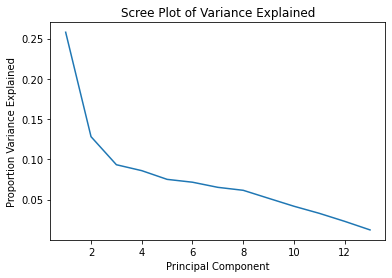

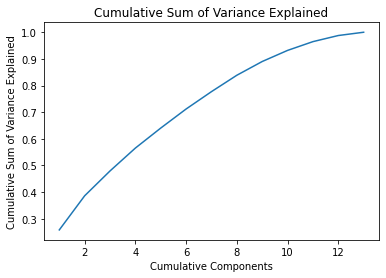

In [ ]:
# plot scree and cumulative sum of variance explained
plt.figure()
explained_var = spotify_model.stages[-1].explainedVariance
plt.plot(np.arange(1, len(explained_var)+1), explained_var)
plt.title("Scree Plot of Variance Explained")
plt.xlabel("Principal Component")
plt.ylabel("Proportion Variance Explained")


cum_sum = np.cumsum(explained_var)
plt.figure()
plt.plot(np.arange(1, len(explained_var)+1), cum_sum)
plt.title("Cumulative Sum of Variance Explained")
plt.xlabel("Cumulative Components")
plt.ylabel("Cumulative Sum of Variance Explained")

In [ ]:
# final pca pipeline with k=10 this time
spotify_pipe = Pipeline(stages=[feature.VectorAssembler(inputCols=['acousticness', 'danceability', 'energy', 'explicit', 
                                                                   'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
                                                                   'speechiness', 'tempo', 'valence', 'year'],
                                                        outputCol= 'features'),
                                feature.StandardScaler(withMean=True, withStd=True, inputCol='features', outputCol='centered_features'),
                                feature.Normalizer(inputCol='centered_features', outputCol='norm_features'),
                                feature.PCA(k=10, inputCol='centered_features', outputCol='pca_score')
                                ])

spotify_model = spotify_pipe.fit(spotify_df)
spotify_pca = spotify_model.transform(spotify_df)
print(sum(spotify_model.stages[-1].explainedVariance))
spotify_pca.show()

0.931831680998153
+-------------------+--------------------+-------------------+-----------+-------------------+--------+------------------+---+-------------------+-------------------+----+--------------------+----------+------------+-------------------+------------------+-------------------+----+--------------------+--------------------+--------------------+--------------------+
|       acousticness|             artists|       danceability|duration_ms|             energy|explicit|  instrumentalness|key|           liveness|           loudness|mode|                name|popularity|release_date|        speechiness|             tempo|            valence|year|            features|   centered_features|       norm_features|           pca_score|
+-------------------+--------------------+-------------------+-----------+-------------------+--------+------------------+---+-------------------+-------------------+----+--------------------+----------+------------+-------------------+----------------

##### Recommendation

In [ ]:
# define function that calcuate distance
def l2_dist(c1, c2):    
    return float(np.sqrt((c1 - c2).T.dot((c1 - c2))))

# define a function that output similar songs
def get_nearest_songs(song, num_nearest_song):
  l2_dist_udf = fn.udf(l2_dist, types.FloatType())
  song_df = spotify_pca.\
              where(spotify_pca.name == song).\
              select(fn.col("pca_score").alias('song_scores')).\
              join(spotify_pca).\
              withColumn('dist', l2_dist_udf('pca_score', 'song_scores')).\
              orderBy(fn.asc('dist')).\
              where('dist != 0').\
              select("name", 'artists','dist').\
              limit(num_nearest_song)
  
  return song_df.toPandas()

In [ ]:
get_nearest_songs('Sad Forever', 5)

,name,artists,dist
0,17,['Pink Sweat$'],1.071972
1,Wonder What She Thinks of Me,['Chloe x Halle'],1.084852
2,Strangers,['Mt. Joy'],1.095840
3,How Would I Know,"['Kygo', 'Oh Wonder']",1.138228
4,Church In A Chevy,['Jordan Davis'],1.179639


#### K-Means Clustering

In [ ]:
%%time
# Code Source: https://runawayhorse001.github.io/LearningApacheSpark/clustering.html
# define a function that finds the best k
def optimal_k(df_in,k_min, k_max,num_runs):
    '''
    Determine optimal number of clusters by using Silhoutte Score Analysis.
    :param df_in: the input dataframe
    :param index_col: the name of the index column
    :param k_min: the train dataset
    :param k_min: the minmum number of the clusters
    :param k_max: the maxmum number of the clusters
    :param num_runs: the number of runs for each fixed clusters

    :return k: optimal number of the clusters
    :return silh_lst: Silhouette score
    :return r_table: the running results table

    :author: Wenqiang Feng
    :email:  von198@gmail.com
    '''

    silh_lst = []
    k_lst = np.arange(k_min, k_max+1)

    centers = pd.DataFrame()

    for k in k_lst:
        silh_val = []
        for run in np.arange(1, num_runs+1):

            # Trains a k-means model.
            kmeans = clustering.KMeans(k=k)
            model = kmeans.fit(df_in)

            # Make predictions
            predictions = model.transform(df_in)

            # Evaluate clustering by computing Silhouette score
            evaluator = ClusteringEvaluator()
            silhouette = evaluator.evaluate(predictions)
            silh_val.append(silhouette)

        silh_array=np.asanyarray(silh_val)
        silh_lst.append(silh_array.mean())

    silhouette = pd.DataFrame(list(zip(k_lst,silh_lst)),columns = ['k', 'silhouette'])

    return k_lst[np.argmax(silh_lst, axis=0)], silhouette

highest_score, silh_lst = optimal_k(spotify_pca,k_min=2, k_max=10,num_runs=5)

CPU times: user 2.77 s, sys: 946 ms, total: 3.72 s
Wall time: 2min 7s


k with the highest silhoutte score:  2 



Text(0.5, 1.0, 'Silhouette Score vs K')

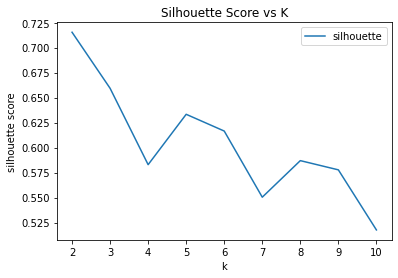

In [ ]:
silhouette = spark.createDataFrame(silh_lst).toPandas()
print('k with the highest silhoutte score: ', highest_score, '\n')

# plot
silhouette.plot('k', 'silhouette')
plt.ylabel('silhouette score')
plt.title('Silhouette Score vs K')

In [ ]:
# print silhouette score for each k
print(silhouette)

    k  silhouette
0   2    0.715416
1   3    0.659314
2   4    0.582901
3   5    0.633299
4   6    0.616537
5   7    0.550347
6   8    0.586932
7   9    0.577700
8  10    0.517593


In [ ]:
# final kmeans pipeline
spotify_kmeans_pipe = Pipeline(stages=[feature.VectorAssembler(inputCols=['acousticness', 'danceability', 'energy', 'explicit', 
                                                                   'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
                                                                   'speechiness', 'tempo', 'valence', 'year'],
                                                                outputCol= 'features'),
                                       clustering.KMeans(k=6)])

spotify_kmeans_model = spotify_kmeans_pipe.fit(spotify_df)
spotify_kmeans = spotify_kmeans_model.transform(spotify_df)
spotify_kmeans.show()

+-------------------+--------------------+-------------------+-----------+-------------------+--------+------------------+---+-------------------+-------------------+----+--------------------+----------+------------+-------------------+------------------+-------------------+----+--------------------+----------+
|       acousticness|             artists|       danceability|duration_ms|             energy|explicit|  instrumentalness|key|           liveness|           loudness|mode|                name|popularity|release_date|        speechiness|             tempo|            valence|year|            features|prediction|
+-------------------+--------------------+-------------------+-----------+-------------------+--------+------------------+---+-------------------+-------------------+----+--------------------+----------+------------+-------------------+------------------+-------------------+----+--------------------+----------+
|             0.0902|    ['Old Dominion']|              0.633

In [ ]:
# print silhouette score
ClusteringEvaluator().evaluate(spotify_kmeans)

0.6165366739209911

In [ ]:
# display frequency of each cluster
freq_cluster = spotify_kmeans.groupby('prediction').count()
freq_cluster.sort('prediction').show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0| 2944|
|         1| 1976|
|         2|   58|
|         3| 2471|
|         4| 3043|
|         5| 1164|
+----------+-----+

